In [80]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopy.distance
import geocoder
import inflect

p = inflect.engine()
pd.options.plotting.backend = "plotly"

In [81]:
DATA_PATH = os.path.join(
    os.path.dirname(os.path.abspath("__file__")), os.pardir, "data", "processed"
)

## Import and merge data

In [82]:
nasa_all_df = pd.read_csv(os.path.join(DATA_PATH, os.pardir, "nasa", "nasa_global_landslide_catalog_point.csv"))
nasa_articles_df = pd.read_csv(os.path.join(DATA_PATH, "nasa_filtered.tsv"), sep="\t")
nasa_time_df = pd.read_csv(os.path.join(DATA_PATH, "time_training_data.csv"), index_col=0)
nasa_loc_df = pd.read_csv(os.path.join(DATA_PATH, "train_set_location.csv"), index_col=0)

In [83]:
nasa_dates_df = pd.read_csv(os.path.join(DATA_PATH, "news_text.csv"))
nasa_articles_df["article_publish_date"] = nasa_dates_df["dates"]

In [84]:
nasa_all_df.columns

Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')

In [85]:
nasa_df = pd.merge(
    nasa_all_df[
        [
            "event_id",
            "event_date",
            "event_time",
            "latitude",
            "longitude",
            "location_description",
            "location_accuracy",
            "landslide_category",
            "landslide_trigger",
            "fatality_count",
            "country_name",
            "admin_division_name",
            "gazetteer_closest_point",
        ]
    ],
    nasa_articles_df,
    how="inner",
    left_index=True,
    right_on="id",
).reset_index(drop=True)

nasa_df["landslide_trigger"] = nasa_df["landslide_trigger"].str.lower()
nasa_df["landslide_trigger"] = nasa_df["landslide_trigger"].map(
    lambda x: np.nan
    if x == "other" or x == "no_apparent_trigger" or x == "unknown"
    else x
)
nasa_df["landslide_category"] = nasa_df["landslide_category"].str.lower()
nasa_df["landslide_category"] = nasa_df["landslide_category"].map(
    lambda x: np.nan if x == "other" or x == "unknown" else x
)

nasa_df["article_publish_date"] = nasa_df["article_publish_date"].fillna("")
nasa_df["source_link"] = nasa_df["source_link"].fillna("")
nasa_df["landslide_category"] = nasa_df["landslide_category"].fillna("")
nasa_df["landslide_trigger"] = nasa_df["landslide_trigger"].fillna("")

nasa_df.shape


(3216, 24)

In [86]:
nasa_df["landslide_trigger"].value_counts()

downpour                   1100
rain                        871
                            452
continuous_rain             288
tropical_cyclone            154
monsoon                      64
snowfall_snowmelt            63
construction                 60
mining                       52
flooding                     41
earthquake                   33
leaking_pipe                 14
freeze_thaw                  12
dam_embankment_collapse      10
volcano                       2
Name: landslide_trigger, dtype: int64

In [87]:
nasa_df["landslide_category"].value_counts()

landslide              2104
mudslide                631
rock_fall               245
debris_flow              91
complex                  54
                         35
creep                    14
riverbank_collapse       13
translational_slide      11
snow_avalanche            5
rotational_slide          5
earth_flow                4
lahar                     4
Name: landslide_category, dtype: int64

In [32]:
from plotnine import *

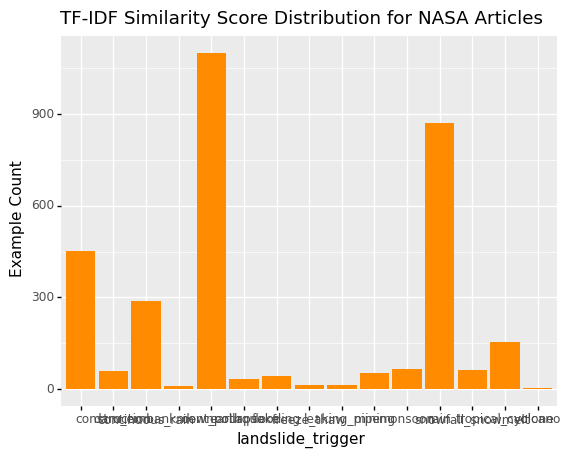

<ggplot: (679627469)>

In [47]:
(
    ggplot(nasa_df, aes(x="landslide_trigger")) +
    geom_bar(fill="darkorange") +
    theme(axis_text_x=element_text(angle=75, hjust=1)) +
    ggtitle("TF-IDF Similarity Score Distribution for NASA Articles") +
    ylab("Example Count") +
    # xlab("TF-IDF Similarity Score") +
    theme_gray()
)

In [56]:
nasa_df["landslide_trigger"].value_counts().reset_index()

,index,landslide_trigger
0,downpour,1100
1,rain,871
2,,452
3,continuous_rain,288
4,tropical_cyclone,154
5,monsoon,64
6,snowfall_snowmelt,63
7,construction,60
8,mining,52
9,flooding,41


In [70]:
fig = px.colors.qualitative.swatches()
fig.show()

In [78]:
import plotly.express as px

fig = px.bar(
    nasa_df["landslide_trigger"]
    .str.replace("_", " ")
    .apply(lambda x: '""' if x == "" else x)
    .value_counts()
    .reset_index()
    .iloc[::-1],
    x="landslide_trigger",
    y="index",
    labels={
        "landslide_trigger": "Trigger Count",
        "index": "Trigger Type",
    },
    color_discrete_sequence=["PeachPuff"],
    template="plotly_white"
)
fig.show()


In [79]:
import plotly.express as px

fig = px.bar(
    nasa_df["landslide_category"]
    .str.replace("_", " ")
    .apply(lambda x: '""' if x == "" else x)
    .value_counts()
    .reset_index()
    .iloc[::-1],
    x="landslide_category",
    y="index",
    labels={
        "landslide_category": "Category Count",
        "index": "Category Type",
    },
    color_discrete_sequence=["PeachPuff"],
    template="plotly_white"
)
fig.show()


In [31]:
nasa_df["landslide_trigger"].plot.bar()

In [11]:
nasa_df["landslide_category"].value_counts()

landslide              2104
mudslide                631
rock_fall               245
debris_flow              91
complex                  54
                         35
creep                    14
riverbank_collapse       13
translational_slide      11
snow_avalanche            5
rotational_slide          5
earth_flow                4
lahar                     4
Name: landslide_category, dtype: int64

In [231]:
nasa_all_df["location_accuracy"]

0            5km
1        unknown
2           50km
3          exact
4            1km
          ...   
35647       25km
35648       25km
35649        5km
35650       50km
35651       25km
Name: location_accuracy, Length: 35652, dtype: object

In [115]:
nasa_df

,event_id,location_description,landslide_category,landslide_trigger,fatality_count,country_name,admin_division_name,gazetteer_closest_point,id,source_link,article_publish_date,article_title,article_text,keywords,article_summary,category,text,lang,len_article
0,6949,Dabhol village of Maharashtra's Ratnagiri dist...,landslide,downpour,12.0,India,Maharashtra,Mahar Wari,0,http://www.dnaindia.com/india/report-ratnagiri...,NaN,Ratnagiri landslide: At least 12 people feared...,Reported By: | Edited By: |Source: ANI |Update...,"['rescue', 'landslide', 'heavy', 'village', 't...",Reported By: | Edited By: |Source: ANI |Update...,pos,Ratnagiri landslide: At least 12 people feared...,en,132
1,7378,Ghizar District,rock_fall,earthquake,4.0,Pakistan,Northern Areas,Gupis,1,http://pamirtimes.net/2015/10/26/earthquake-af...,2015-10-26 00:00:00,"Earthquake Aftermath: 8 killed, 20 plus injure...",Gilgit/Hunza/Skardu: At least eight people wer...,"['landslide', 'killed', 'plus', 'injured', 'hu...",Gilgit/Hunza/Skardu: At least eight people wer...,pos,"Earthquake Aftermath: 8 killed, 20 plus injure...",en,460
2,6852,Montenegro,landslide,downpour,0.0,Montenegro,Budva,Budva,6,http://www.euronews.com/nocomment/2015/03/10/m...,2015-03-10 00:00:00,Landslide destroys road in Montenegro,A huge landslide in Montenegro damaged more th...,"['metres', 'highway', 'landslide', 'destroys',...",A huge landslide in Montenegro damaged more th...,pos,Landslide destroys road in Montenegro\nA huge ...,en,28
3,7392,Interstate 5 in the Fort Tejon area,mudslide,downpour,0.0,United States,California,Grapevine,9,http://www.latimes.com/local/weather/la-me-ln-...,2015-12-13 00:00:00,Northbound Interstate 5 reopens after mudslide...,A mudslide triggered by a storm moving through...,"['winds', 'reopens', 'slams', 'mudslide', 'exp...",A mudslide triggered by a storm moving through...,pos,Northbound Interstate 5 reopens after mudslide...,en,253
4,9423,"Milkbank, Portland, Jamaica",mudslide,rain,0.0,Jamaica,Portland,Manchioneal,11,http://jamaica-star.com/article/news/20160425/...,2016-04-25 00:00:00,Dasheen money lost in mudslide,When Hubert Palmer left his home last Thursday...,"['farmer', 'left', 'mudslide', 'family', 'hous...",When Hubert Palmer left his home last Thursday...,neg,Dasheen money lost in mudslide\nWhen Hubert Pa...,en,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,5081,On County Road 27 -- The Stove Prairie Road --...,landslide,downpour,0.0,United States,Colorado,Cache la Poudre,35610,http://www.reporterherald.com/ci_23649025/weat...,2013-07-12 15:10:08+00:00,Mudslides close Poudre Canyon highway at Ted’s...,The Larimer County Sheriff’s Office reported a...,"['warning', 'highway', 'service', 'warned', 'w...",The Larimer County Sheriff’s Office reported a...,pos,Mudslides close Poudre Canyon highway at Ted’s...,en,258
3212,7279,Tamenglong Ward No-IV,mudslide,monsoon,0.0,India,Manipur,Brail Range,35613,http://e-pao.net/GP.asp?src=Snipp16..250715.jul15,NaN,"Mudslide destroys garage, jeep in Tamenglong :...","Mudslide destroys garage, jeep in Tamenglong\n...","['users', 'headlines', 'jul15', 'garage', 'mud...","Mudslide destroys garage, jeep in TamenglongSo...",pos,"Mudslide destroys garage, jeep in Tamenglong :...",en,185
3213,6657,"Balibadon, Surigao del Sur",landslide,continuous_rain,0.0,Philippines,Surigao del Sur,Burgos,35633,http://www.rappler.com/nation/80272-floods-lan...,2015-01-09 09:16:11+00:00,"Flood, landslides hit Surigao del Sur","Heavy, continuous rains cause flooding and lan...","['flood', 'landslides', 'work', 'town', 'surig...","Heavy, continuous rains cause flooding and lan...",pos,"Flood, landslides hit Surigao del Sur\nHeavy, ...",en,282
3214,9185,Phidim-Raanke section of the Mechi Highway at ...,rock_fall,NaN,0.0,Nepal,Mechi,Beteni,35646,http://www.myrepublica.com/news/2748,NaN,Mudslide blocks Mechi Highway,"PAANCHTHAR, July 26: The Phidim-Raanke section...","['temple', 'stated', 'highway', 'blocks', 'l

In [195]:
nasa_df.query("id == 208")

,event_id,location_description,landslide_category,landslide_trigger,fatality_count,country_name,admin_division_name,gazetteer_closest_point,id,source_link,article_publish_date,article_title,article_text,keywords,article_summary,category,text,lang,len_article
52,79,"village in Sichuan province's Garze region, He...",landslide,rain,18.0,China,Gansu,Xihe,208,http://news.bbc.co.uk/1/hi/world/asia-pacific/...,2007-05-26 07:25:32,Western China landslides kill 21,Twelve people died and another 18 were injured...,"['mudslides', 'washed', 'landslides', 'rain', ...",Twelve people died and another 18 were injured...,pos,Western China landslides kill 21\nTwelve peopl...,en,178


In [116]:
nasa_time_df = nasa_time_df.rename(columns={"contains correct time/date phrase" : "pos_sentence"})
nasa_time_df

,id,gold_date,extracted_dates,Unnamed: 0,text,GPE,LOC,DATE,TIME,index,normalized_date,normalized_time,pos_sentence,date_phrase for normalization,normalized interval(from date),time_phrase for normalization,normalized interval(from time)
0,0,2015-06-22 3:30,2015-06-22T14:30:00,0,Reported By: | Edited By: |Source: ANI |Update...,NaN,NaN,"Aug 04 , 2015",11:39 AM IST,0,None|,"2015/06/22, 11:09-2015/06/22, 12:09|",neg,NaN,NaN,NaN,NaN
1,0,2015-06-22 3:30,2015-06-22T14:30:00,1,At least 12 people are feared to be buried und...,Dabhol|Maharashtra|Ratnagiri,NaN,NaN,NaN,1,NaN,NaN,neg,NaN,NaN,NaN,NaN
2,0,2015-06-22 3:30,2015-06-22T14:30:00,2,The landslide is said to have taken place at 3...,NaN,NaN,NaN,3:30 am,2,NaN,"2015/06/22, 03:00-2015/06/22, 04:00|",pos,NaN,NaN,3:30 am,"2015/06/22, 03:00-2015/06/22, 04:00"
3,0,2015-06-22 3:30,2015-06-22T14:30:00,3,Ratnagiri (Maharashtra): Landslide occurred at...,Ratnagiri|Maharashtra,NaN,NaN,3 : 30 am today,3,NaN,"2015/06/22, 03:00-2015/06/22, 04:00|",pos,NaN,NaN,3 : 30 am today,"2015/06/22, 03:00-2015/06/22, 04:00"
4,0,2015-06-22 3:30,2015-06-22T14:30:00,4,"pic.twitter.com/MOcmTxnAZX June 22, 2015",NaN,NaN,"June 22 , 2015",NaN,4,"2015/06/22, 00:00-2015/06/22, 23:59|",NaN,pos,"June 22 , 2015","2015/06/22, 00:00-2015/06/22, 23:59",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,35646,2016-07-25 23:00,2016-07-26,26128,"Meanwhile, the Kanchanjunga Academy Higher Sec...",Phidim-1,NaN,NaN,NaN,21422,NaN,NaN,neg,NaN,NaN,NaN,NaN
21423,35649,2014-11-06 18:00,2014-11-07 16:45:00+05:30,26129,Follow us on landslide blocks doda batote high...,Jammu,NaN,NaN,NaN,21423,NaN,NaN,neg,NaN,NaN,NaN,NaN
21424,35649,2014-11-06 18:00,2014-11-07 16:45:00+05:30,26130,The highway was blocked after a landslide hit ...,Doda,NaN,NaN,last evening,21424,NaN,"2014/11/06, 18:00-2014/11/06, 22:00|",pos,NaN,NaN,last evening,"2014/11/06, 18:00-2014/11/06, 22:00"
21425,35649,2014-11-06 18:00,2014-11-07 16:45:00+05:30,26131,He said that the work to open the highway was ...,NaN,NaN,today,evening,21425,"2014/11/07, 00:00-2014/11/07, 23:59|","2014/11/07, 18:00-2014/11/07, 22:00|",neg,NaN,NaN,NaN,NaN


In [229]:
nasa_time_df.query("pos_sentence == 'pos'")

,id,gold_date,extracted_dates,Unnamed: 0,text,GPE,LOC,DATE,TIME,index,normalized_date,normalized_time,pos_sentence,date_phrase for normalization,normalized interval(from date),time_phrase for normalization,normalized interval(from time)
2,0,2015-06-22 3:30,2015-06-22T14:30:00,2,The landslide is said to have taken place at 3...,NaN,NaN,NaN,3:30 am,2,NaN,"2015/06/22, 03:00-2015/06/22, 04:00|",pos,NaN,NaN,3:30 am,"2015/06/22, 03:00-2015/06/22, 04:00"
3,0,2015-06-22 3:30,2015-06-22T14:30:00,3,Ratnagiri (Maharashtra): Landslide occurred at...,Ratnagiri|Maharashtra,NaN,NaN,3 : 30 am today,3,NaN,"2015/06/22, 03:00-2015/06/22, 04:00|",pos,NaN,NaN,3 : 30 am today,"2015/06/22, 03:00-2015/06/22, 04:00"
4,0,2015-06-22 3:30,2015-06-22T14:30:00,4,"pic.twitter.com/MOcmTxnAZX June 22, 2015",NaN,NaN,"June 22 , 2015",NaN,4,"2015/06/22, 00:00-2015/06/22, 23:59|",NaN,pos,"June 22 , 2015","2015/06/22, 00:00-2015/06/22, 23:59",NaN,NaN
6,0,2015-06-22 3:30,2015-06-22T14:30:00,6,pic.twitter.com/a5mMtI2hwB — ANI (@ANI_news) J...,NaN,NaN,"June 22 , 2015",Earlier in the day,6,"2015/06/22, 00:00-2015/06/22, 23:59|",None|,pos,"June 22 , 2015","2015/06/22, 00:00-2015/06/22, 23:59",NaN,NaN
7,1,2015-10-26 0:00,2015-10-26 00:00:00,7,Gilgit/Hunza/Skardu: At least eight people wer...,Gilgit-Baltistan,NaN,today,NaN,7,"2015/10/26, 00:00-2015/10/26, 23:59|",NaN,pos,today,"2015/10/26, 00:00-2015/10/26, 23:59",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21389,35598,2015-07-04 18:00,2015-07-05T12:37:00,26095,GTA chief Bimal Gurung yesterday called up Wes...,West Bengal,NaN,yesterday,NaN,21389,"2015/07/04, 00:00-2015/07/04, 23:59|",NaN,pos,yesterday,"2015/07/04, 00:00-2015/07/04, 23:59",NaN,NaN
21391,35606,2014-06-30 15:00,2014-07-01 00:00:00,26097,GENERAL SANTOS CITY (MindaNews/01 July) — An u...,SANTOS CITY|MindaNews|Tampakan|South Cotabato,NaN,Monday,afternoon,21391,"2014/06/30, 00:00-2014/06/30, 23:59|","2014/07/01, 12:00-2014/07/01, 17:00|",pos,Monday,"2014/06/30, 00:00-2014/06/30, 23:59",NaN,NaN
21402,35610,2013-07-12 16:00,2013-07-12 15:10:08+00:00,26108,"About 4 p.m., the Sheriff’s Office also report...",Colorado,NaN,NaN,About 4 p.m.,21402,NaN,"2013/07/12, 15:30-2013/07/12, 16:30|",pos,NaN,NaN,About 4 p.m.,"2013/07/12, 15:30-2013/07/12, 16:30"
21420,35646,2016-07-25 23:00,2016-07-26,26126,"PAANCHTHAR, July 26: The Phidim-Raanke section...",PAANCHTHAR|Phidim-Raanke|Samdin|Phidim-2,NaN,July 26,last night,21420,"2015/07/26, 00:00-2015/07/26, 23:59|","2016/07/25, 23:00-2016/07/26, 04:00|",pos,NaN,NaN,last night,"2016/07/25, 23:00-2016/07/26, 04:00"


In [7]:
nasa_loc_df

,id,text,location_description,locations,dates,pos_sentence,number_of_pos_sent,contain_pos_sent
0,0,Reported By: | Edited By: |Source: ANI |Update...,Dabhol village of Maharashtra's Ratnagiri dist...,|,"Aug 04 , 2015|11:39 AM IST",No,1,True
1,0,At least 12 people are feared to be buried und...,Dabhol village of Maharashtra's Ratnagiri dist...,Dabhol|Maharashtra|Ratnagiri|,|,Yes,1,True
2,0,The landslide is said to have taken place at 3...,Dabhol village of Maharashtra's Ratnagiri dist...,|,|3:30 am,No,1,True
3,0,Ratnagiri (Maharashtra): Landslide occurred at...,Dabhol village of Maharashtra's Ratnagiri dist...,Ratnagiri|Maharashtra|,|3 : 30 am today,No,1,True
4,0,"pic.twitter.com/MOcmTxnAZX June 22, 2015",Dabhol village of Maharashtra's Ratnagiri dist...,|,"June 22 , 2015|",No,1,True
...,...,...,...,...,...,...,...,...
26128,35646,"Meanwhile, the Kanchanjunga Academy Higher Sec...",Phidim-Raanke section of the Mechi Highway at ...,Phidim-1|,|,No,1,True
26129,35649,Follow us on landslide blocks doda batote high...,"Chakwa bridge, 9 kilomters short of Doda",Jammu|,|,No,1,True
26130,35649,The highway was blocked after a landslide hit ...,"Chakwa bridge, 9 kilomters short of Doda",Doda|,|last evening,Yes,1,True
26131,35649,He said that the work to open the highway was ...,"Chakwa bridge, 9 kilomters short of Doda",|,today|evening,No,1,True


## Get best locations

In [15]:
def get_distance(p1, p2):
    """Get the geographical distance between two points"""
    if p1 and p2:
        return round(geopy.distance.geodesic(p1, p2).km, 3)
    else:
        return None

def get_smallest_region_idx(locs):
    """
    Parameters
    ----------
    locs : list of dictionary
        a list of dictionary containing latitude, longitude, 
        northeast point, southwest point for all the location 
        entities in the positive sentence
    
    Returns
    ----------
        an integer indicating the index of the location entity 
        that has the smallest region
    """
    dists = [get_distance(loc['northeast'], loc['southwest']) for loc in locs]
    return dists.index(min(dists))

def filter_location_by_size(locs):
    geolocs = []
    for loc in locs:
        geocoded = geocoder.arcgis(loc).json
        if geocoded:
            geoloc = geocoded['bbox']
            geoloc['lat'], geoloc['lng'] = geocoded['lat'], geocoded['lng']
            geolocs.append(geoloc)

    if geolocs:
        j = get_smallest_region_idx(geolocs)
        return locs[j]
    else:
        return ""

In [105]:
def extract_location(locations, location_description):
    matching_locations = []

    if not type(locations) == list or not type(location_description) == str:
        return []

    for location in locations:
        if location and location in location_description:
            matching_locations.append(location)
    return matching_locations


location_tags = []
for id in tqdm(nasa_df["id"].to_numpy()):
    location_rows = nasa_loc_df.query(f"id == {id} and pos_sentence == 'Yes'")

    location = []
    for location_row_id in range(location_rows.shape[0]):
        location.extend(
            extract_location(
                location_rows.iloc[location_row_id]["locations"].split("|"),
                location_rows.iloc[location_row_id]["location_description"],
            )
        )
        location = list(
            set(
                [
                    loc
                    for loc in location
                    if not any([loc in l for l in location if loc != l])
                ]
            )
        )

    nasa_row = nasa_df.query(f"id == {id}").iloc[0]
    if (
        type(nasa_row["gazetteer_closest_point"]) == str
        and nasa_row["gazetteer_closest_point"] in nasa_row["text"]
    ):
        location.append(nasa_row["gazetteer_closest_point"])
    elif (
        type(nasa_row["admin_division_name"]) == str
        and nasa_row["admin_division_name"] in nasa_row["text"]
    ):
        location.append(nasa_row["admin_division_name"])
    if (
        type(nasa_row["country_name"]) == str
        and nasa_row["country_name"] in nasa_row["text"]
    ):
        location.append(nasa_row["country_name"])

    if not location or len(location) == 0:
        best_location = ""
    elif len(location) == 1:
        best_location = location[0]
    elif len(location) > 1:
        best_location = filter_location_by_size(location)

    location_tags.append(best_location)


100%|██████████| 3216/3216 [55:51<00:00,  1.04s/it]  


## Get best dates

In [170]:
date_tags = []
time_tags = []
weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
for id in tqdm(nasa_df["id"].to_numpy()):
    date_time = nasa_time_df.query(f"id == {id} and pos_sentence == 'pos'")
    date = list(set(date_time["date_phrase for normalization"].dropna().to_numpy()))
    time = list(set(date_time["time_phrase for normalization"].dropna().to_numpy()))

    if not date:
        best_date = ""
    elif len(date) == 1:
        best_date = date[0]
    elif len(date) > 1:
        for d in date:
            if d.lower() == "today":
                best_date = d
                break
            if any(c.isdigit() for c in d):
                best_date = d
                break
            if any(d.lower() == w for w in weekdays):
                best_date = d
                break
        best_date = date[0]

    if not time:
        best_time = ""
    elif len(time) == 1:
        best_time = time[0]
    elif len(time) > 1:
        best_time = time[0]

    date_tags.append(best_date)
    time_tags.append(best_time)


100%|██████████| 3216/3216 [00:06<00:00, 474.07it/s]


## Get casualities

In [221]:
cas_tags = []
for id in tqdm(nasa_df["id"].to_numpy()):
    cas_count = nasa_df.query(f"id == {id}")["fatality_count"].iloc[0]
    text = nasa_df.query(f"id == {id}")["text"].iloc[0]

    if cas_count == cas_count and cas_count > 0:
        if " " + str(int(cas_count)) + " " in text:
            cas_tags.append(str(int(cas_count)))
        elif p.number_to_words(int(cas_count)) in text:
            cas_tags.append(p.number_to_words(int(cas_count)))
        else:
            cas_tags.append("")
    else:
        cas_tags.append("")


100%|██████████| 3216/3216 [00:12<00:00, 255.20it/s]


In [218]:
p.number_to_words(8.0)

'eight point zero'

In [222]:
cas_tags

['12',
 '',
 '',
 '',
 '',
 '',
 '',
 '7',
 '',
 '4',
 '',
 '',
 '',
 '2',
 '',
 '',
 'two',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '6',
 '',
 '',
 '',
 '18',
 '',
 '',
 'three',
 '',
 '',
 'one',
 '',
 'one',
 'one',
 '',
 '6',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'seven',
 '',
 'four',
 '',
 '',
 '',
 '',
 'three',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'two',
 '',
 '',
 '',
 '',
 '',
 '27',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '11',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '3',
 '',
 '',
 '',
 '',
 'three',
 'five',
 'one',
 '',
 '',
 '',
 '',
 '1',
 '',
 '',
 '',
 '',
 'five',
 '',
 'five',
 '3',
 '',
 '19',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'one',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '1',
 '',
 '',
 '',
 '',
 '',
 '',
 'five',
 'one',
 '',
 'five',
 '',
 '4',
 '',
 '',
 '',
 'one',
 '',
 '',

In [224]:
len([c for c in cas_tags if c != ""])

584

In [174]:
date_tags

['June 22 , 2015',
 'today',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'today',
 '',
 '',
 '',
 'Wednesday',
 '',
 '',
 'Tuesday',
 '',
 '',
 'Sunday',
 '',
 '',
 '',
 '',
 '',
 'Thursday',
 '',
 '',
 'yesterday',
 '',
 '',
 '',
 'Thursday',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'Sunday',
 'Friday',
 '',
 '',
 '',
 'Last week',
 '',
 '',
 '',
 '',
 '',
 'Friday',
 '',
 '',
 'July 15 , 2015',
 '',
 '',
 '',
 '',
 'this month',
 '',
 '',
 '',
 '',
 '',
 '',
 'Thursday',
 'August 21 , 2014',
 '',
 '',
 'Sunday',
 '',
 'this week',
 '',
 '',
 'last week',
 'Friday',
 'October 11th , 2016',
 'Saturday',
 '',
 '',
 '',
 '',
 '',
 '',
 'a week',
 '',
 '',
 'Thursday',
 'February 6 , 2017',
 'the past one week',
 '',
 '',
 '',
 '',
 'Last week',
 '',
 'Monday',
 'winter',
 '',
 'Saturday',
 '',
 '',
 'Saturday',
 '',
 '',
 'Sunday',
 '',
 'Wednesday',
 'Today',
 'October 29',
 '',
 '',
 '',
 '',
 'Friday',
 '',
 '',
 'today',
 '',
 '',
 '',
 '',
 '',
 'Aug. 2',
 'Monday',
 'the winter of 2008-09'

In [175]:
time_tags

['3:30 am',
 '',
 '',
 'evening',
 '',
 '',
 '',
 '',
 '',
 'early Saturday morning',
 'this morning',
 '5 am today',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '12.15pm yesterday',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'earlier this morning',
 '',
 '',
 '',
 '',
 'Tuesday afternoon',
 '',
 '',
 '',
 '',
 'around 9:30 p.m. on August 21',
 '',
 '6 p.m . Tuesday',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'about 10 a.m.',
 '',
 '',
 '',
 'tonight',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'the morning',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'the morning',
 '',
 'late Monday',
 '',
 '',
 '',
 '',
 '',
 '',
 'early yesterday',
 '',
 '',
 '',
 'the night',
 '',
 '',
 '',
 'morning',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [176]:
location_tags

['Dabhol',
 'Ghizar District',
 'Montenegro',
 'Fort Tejon',
 'Portland',
 'Keremeos',
 '',
 'Jombang',
 'Elk City',
 'Sichuan Province',
 'Nova Friburgo',
 'Narayangadh-Muglin',
 '',
 'Rizal',
 'Laguna Beach',
 'Pokhara-Baglung-Jomsom',
 'Villa Hidalgo Yalalag',
 'American Fork Canyon',
 'Oregon',
 'Nivsar',
 'Kabandungan',
 'Salyan',
 'Guimaras',
 '',
 '',
 'Alpine',
 'Palakkayam',
 'Varna',
 'Baringo',
 'Billawar tehsil',
 'Barangay Cantao-an',
 'Lianyuan',
 'Philippines',
 'Gundogdu',
 'Contin',
 'Mukilteo',
 'Girard',
 'Beluru-Lapok',
 'Edmonds',
 'Benguet',
 'Threlkeld',
 'Nelson',
 'Tawang',
 'St. Mary',
 'United States',
 'Asheville',
 'Skipton',
 'Roca Tarpeya',
 'Florencia',
 'Liverpool',
 'Sumilao',
 'Kawnpui',
 'Garze',
 '',
 'Gilman Springs',
 'Seppa',
 'Vancouver',
 'VA',
 'Ferozeguda',
 '',
 'El Vigía',
 'LoC',
 'Cincinnati',
 'Narayanghat',
 'Ciregol',
 'Malang',
 'Kalinga',
 'Baguio',
 'Sharon Springs',
 '',
 'Barangay Sinuda',
 'Armenia',
 'Portland',
 'Shaoguan',
 'K

In [134]:
len(location_tags)

3216

In [135]:
len(list(filter(None, location_tags)))

2933

In [136]:
len(list(filter(None, date_tags)))

1118

In [137]:
len(list(filter(None, time_tags)))

367

In [138]:
len(list(filter(None, [date if date else time for date, time in zip(date_tags, time_tags)])))

1332

In [139]:
print(len(time_tags))
print(len(date_tags))
print(len(location_tags))

3216
3216
3216


In [243]:
landslide_data = {"version": "v1.0", "data": []}

for i, article_id in tqdm(enumerate(nasa_df["id"].to_numpy())):
    article_fields = {
        "id": int(article_id),
        "text": nasa_df.iloc[i]["text"],
        "published_date": nasa_df.iloc[i]["article_publish_date"],
        "event_date": nasa_df.iloc[i]["event_date"],
        "latitude": nasa_df.iloc[i]["latitude"],
        "longitude": nasa_df.iloc[i]["longitude"],
        "location_accuracy": nasa_df.iloc[i]["location_accuracy"],
        "url": nasa_df.iloc[i]["source_link"],
        "EVENT_CATEGORY": nasa_df.iloc[i]["landslide_category"],
        "EVENT_TRIGGER": nasa_df.iloc[i]["landslide_trigger"],
        "qas": {
            "LOC": location_tags[i],
            "TIME": time_tags[i],
            "DATE": date_tags[i],
            "CAS": cas_tags[i],
        },
    }
    landslide_data["data"].append(article_fields)


3216it [00:03, 1061.27it/s]


In [238]:
with open(os.path.join(DATA_PATH, "landslide_data.json"), "w") as f:
    json.dump(landslide_data, f)